Train with just koopman matrix and then adding sequence model later


In [1]:
#Make sure you are in directory: Mori-Zwanzig-Autoencoder/
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
import csv


Numerical Experiment Directory

In [3]:
torch.cuda.empty_cache()
exp_dir = "Pre-trained_Models/2DCyl/2DCyl_Trained_Model"

models = []
exp_name_list = ["sl9_nhu40_numobs2_bs16_lr5e-5_dt0.1",\
                 "No_Memory_numobs2"
                 ]

for exp_name in exp_name_list:
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))



sl9_nhu40_numobs2_bs16_lr5e-5_dt0.1
########## Imp Info ##########
System:  2DCyl
No_Memory_numobs2
########## Imp Info ##########
System:  2DCyl
Training without Seqmodel


Plot Learning Curves

Epoch with Minimum train_error:  6477
Epoch with Minimum test_error:  6488


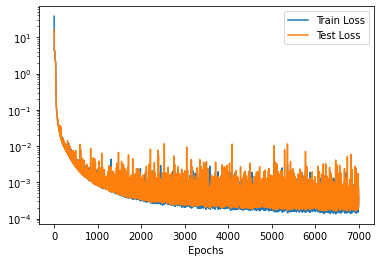

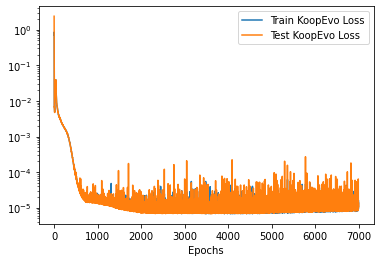

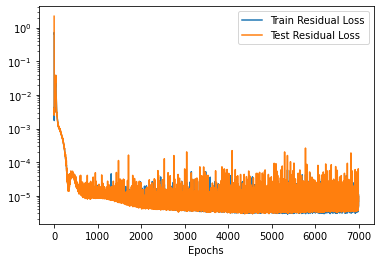

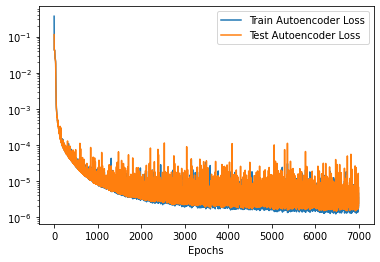

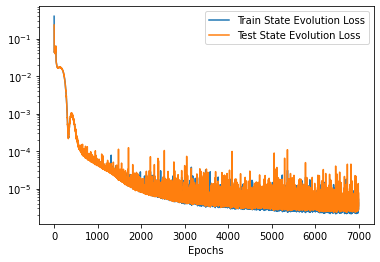

In [4]:
#plot learning curves
models[0].plot_learning_curves()

Load Weights

In [5]:
# Transient Data with numobs5 only
for i in [0,1]:
    print(models[i].autoencoder_model)
    models[i].load_weights(min_test_loss = True)

Autoencoder
Autoencoder


Load Data

In [6]:
#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Test")
dataset = models[model_num].test_dataset
num_trajs = models[model_num].test_num_trajs

State Dims:  7938
Test_Shape:  (1, 1421, 7938)
Time:  0.07645869255065918


Multi Step prediction

In [7]:
Phi_test = models[0].test_data
Phi_test = torch.from_numpy(Phi_test).to(torch.float32).to(models[0].device)

In [10]:
#multistep prediction
timesteps = 2000
initial_step = 0
initial_conditions = Phi_test[:,initial_step,:]

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape)


ic shape: torch.Size([1, 7938])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([2, 1, 2001, 7938])


In [11]:
#Predicted Velocity
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()

#DNS Velocity
U = Phi_test[...,:int(Phi_test.shape[-1]/2)].detach().cpu().numpy()
V = Phi_test[...,int(Phi_test.shape[-1]/2):].detach().cpu().numpy()

U_ms_hat.shape, V_ms_hat.shape, U.shape, V.shape

((2, 1, 2001, 3969), (2, 1, 2001, 3969), (1, 1421, 3969), (1, 1421, 3969))

Figure2 Right

(2, 1, 2001)


Text(0, 0.5, 'Kinetic Energy')

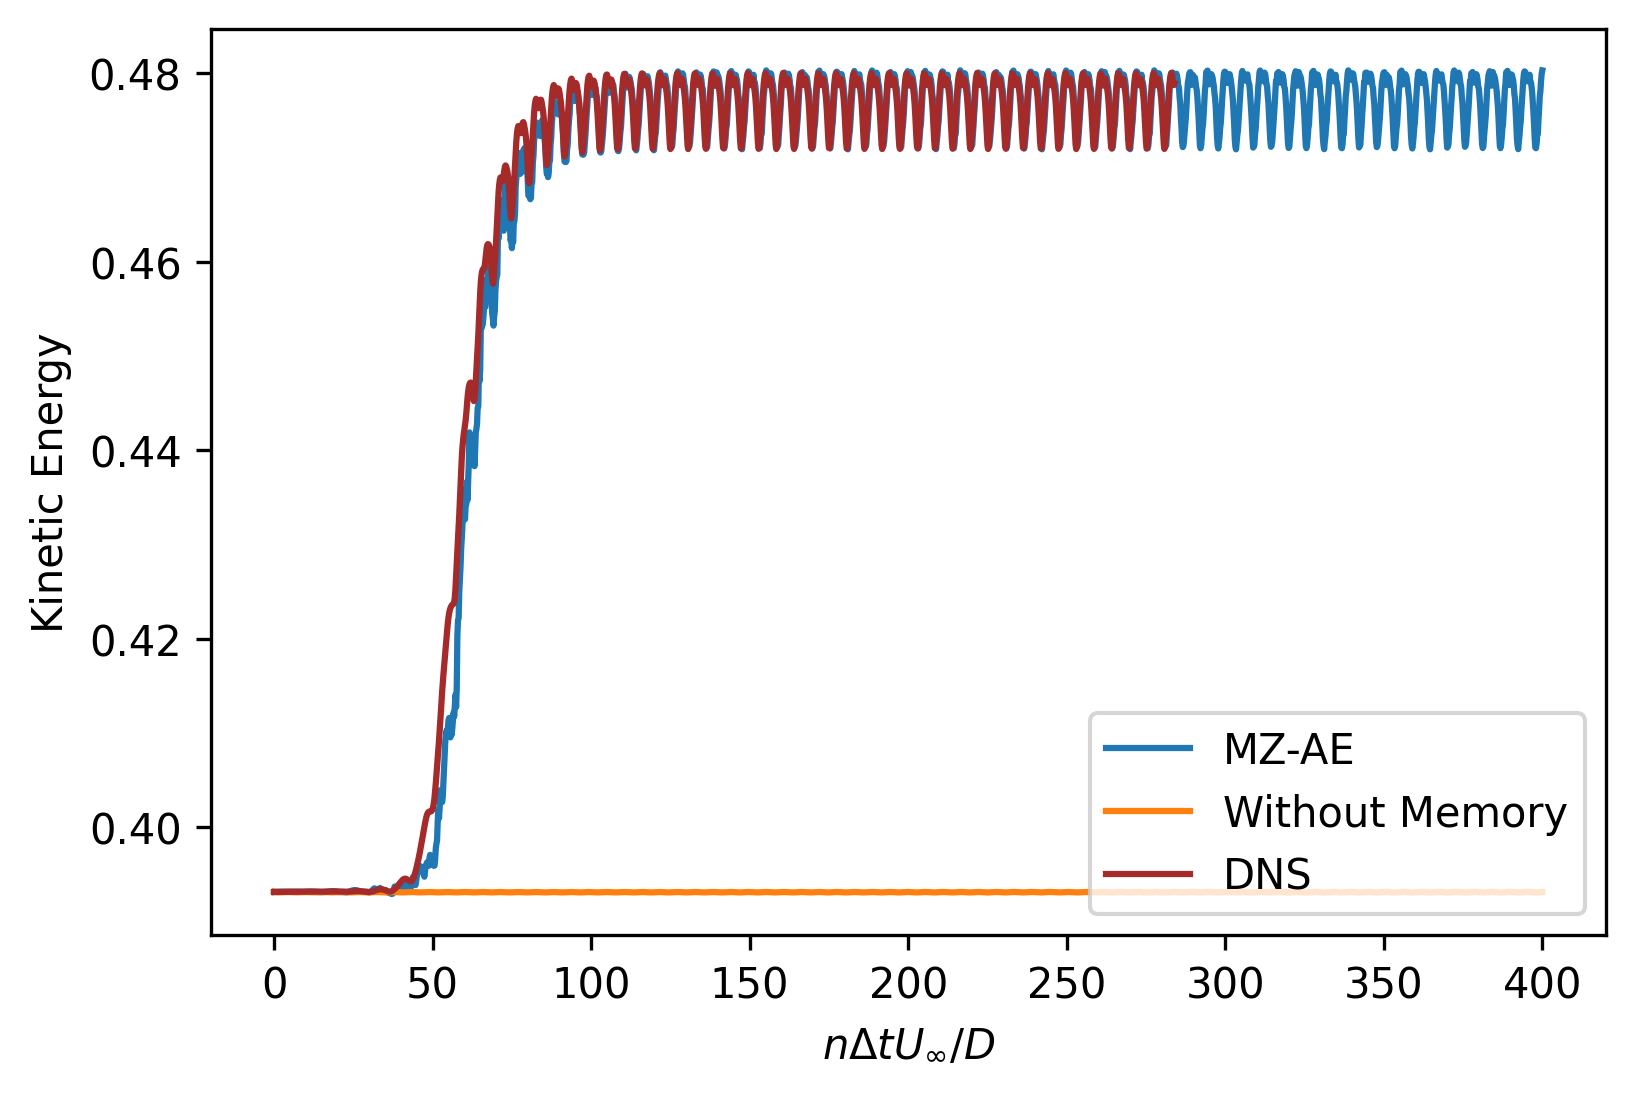

In [12]:
#calculating kinetic energy for multistep prediction 
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k = energy(U, V)
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)

plt.figure(dpi=300)
for i in [0,1]:
    if i==0:
        plt.plot(np.arange(k_ms_pred.shape[-1])*0.2,k_ms_pred[i,0,:], label = f"MZ-AE")
    else:
        plt.plot(np.arange(k_ms_pred.shape[-1])*0.2,k_ms_pred[i,0,:], label = f"Without Memory")

plt.plot(np.arange(k[0,initial_step:].shape[-1])*0.2,k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel(r"$n\Delta t U_{\infty}/D$")
plt.ylabel("Kinetic Energy")


## Latent Mode Evolution

Figure 3: Left

Text(0, 0.5, '$\\tilde{\\mathbf{K}}\\hat{g}_{2}$')

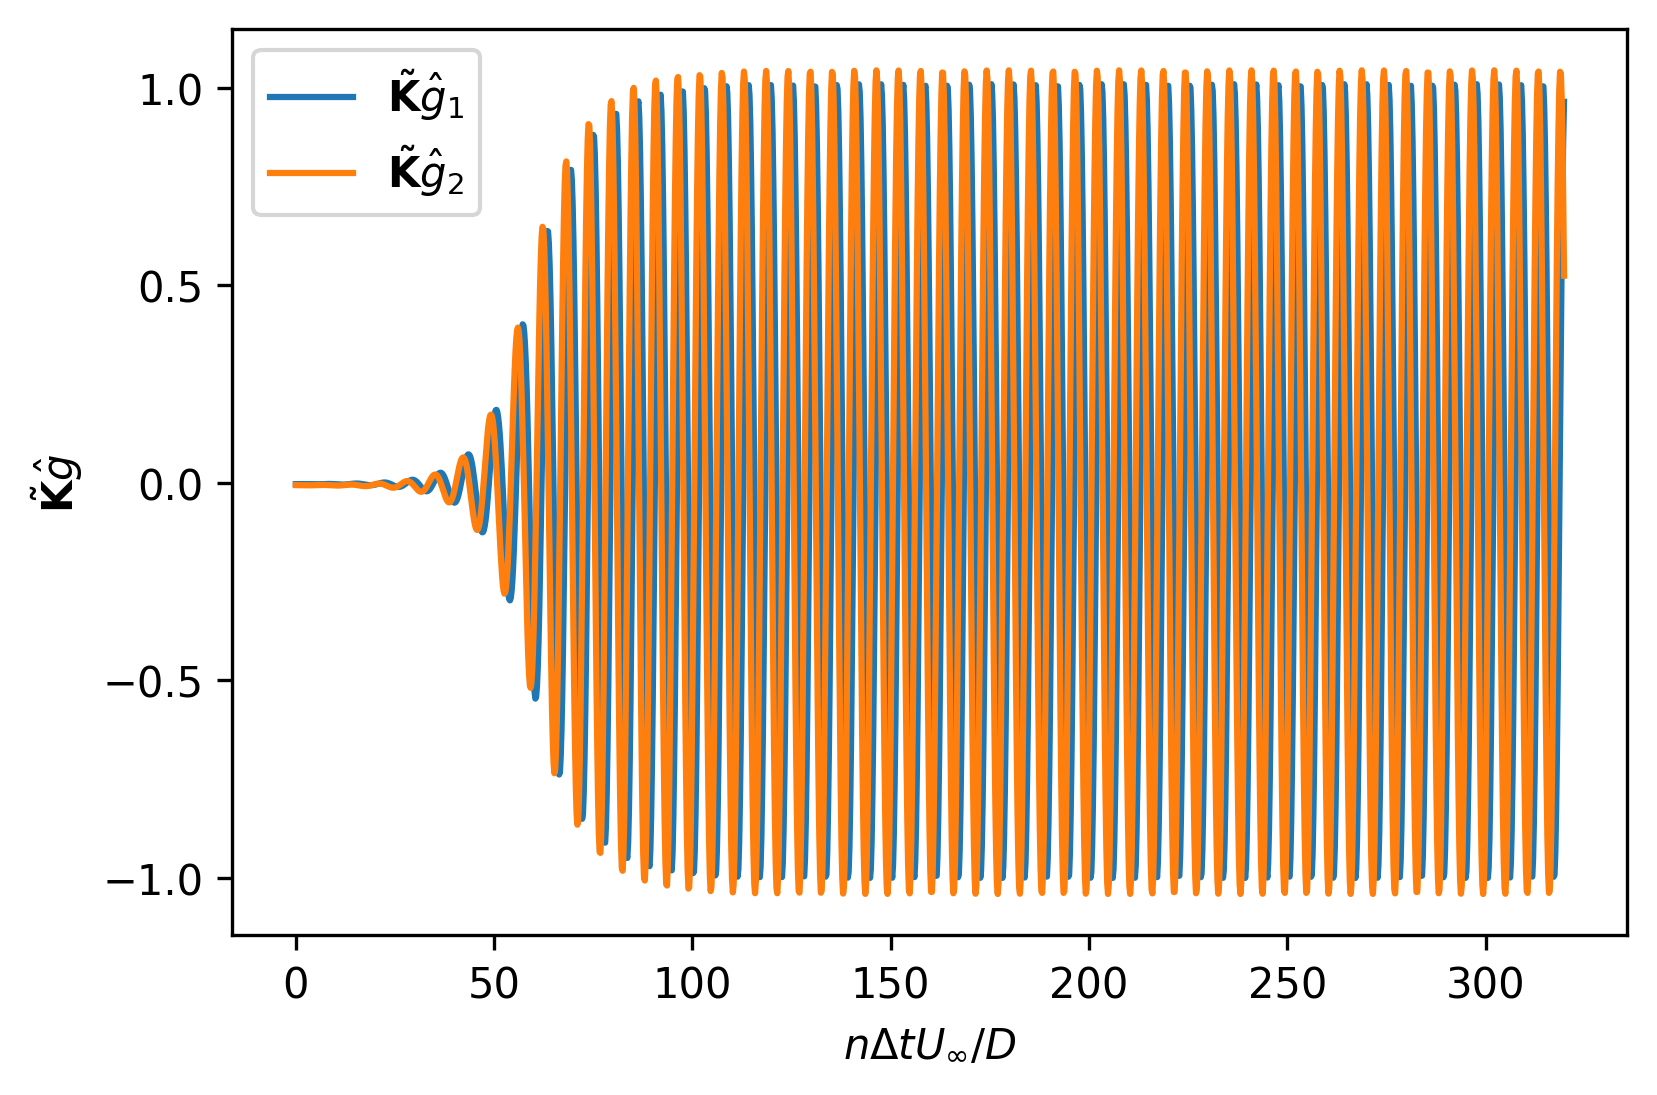

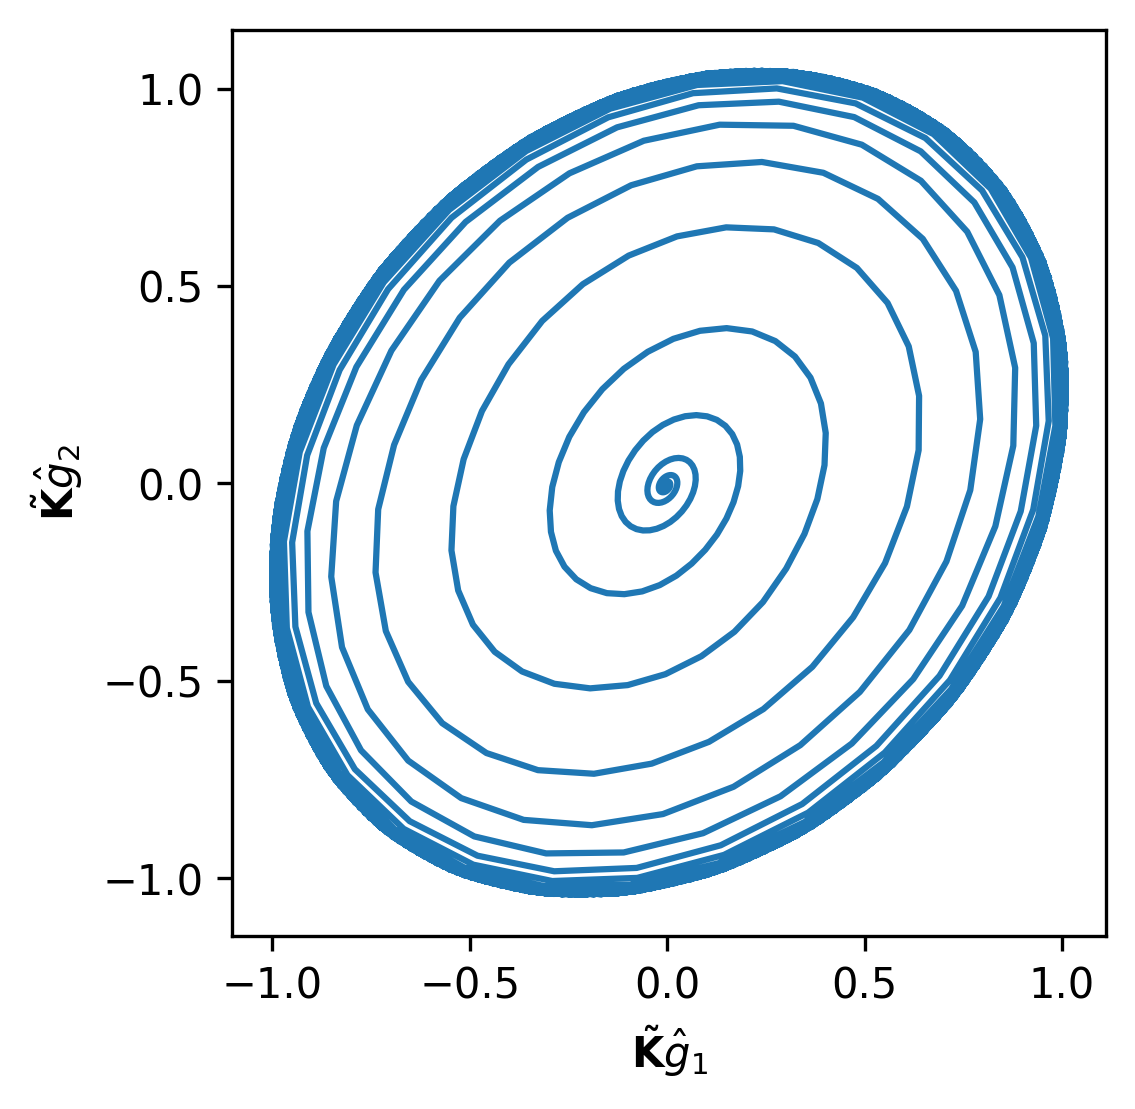

In [15]:
#plotting mode evolution
timesteps_latent = 1600
plt.figure(dpi=300)
model_num = 0
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(np.arange(timesteps_latent)*0.2,xkoop_ms_hat[model_num][0,:timesteps_latent,n].cpu().numpy(), label = r"$\tilde{\mathbf{K}}$"+r"$\hat{g}$"+f"$_{n+1}$")
plt.legend()
plt.xlabel(r"$n\Delta tU_{\infty}/D$")
plt.ylabel(r"$\tilde{\mathbf{K}}\hat{g}$")


plt.figure(dpi=300)
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:timesteps_latent,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:timesteps_latent,1].cpu().numpy())

plt.xlabel(r"$\tilde{\mathbf{K}}\hat{g}_{1}$")
plt.ylabel(r"$\tilde{\mathbf{K}}\hat{g}_{2}$")

Figure 3: Right

Text(0, 0.5, '$\\xi_{2}$')

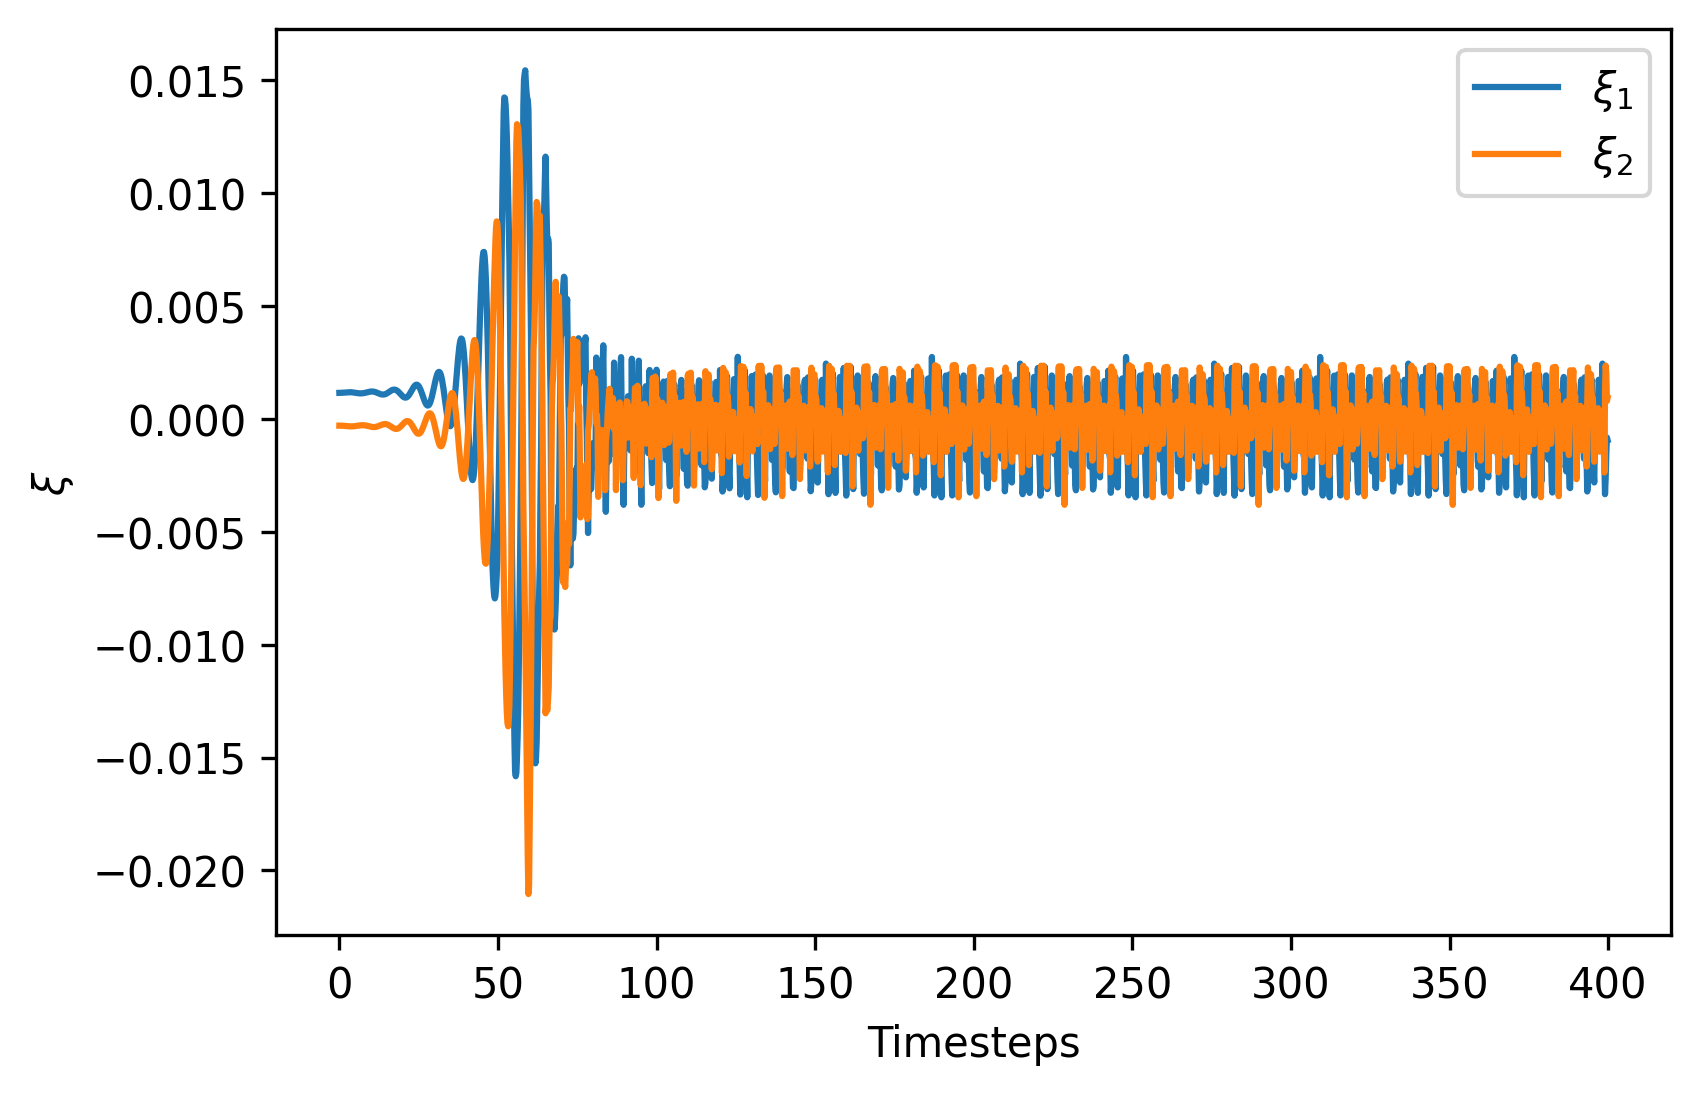

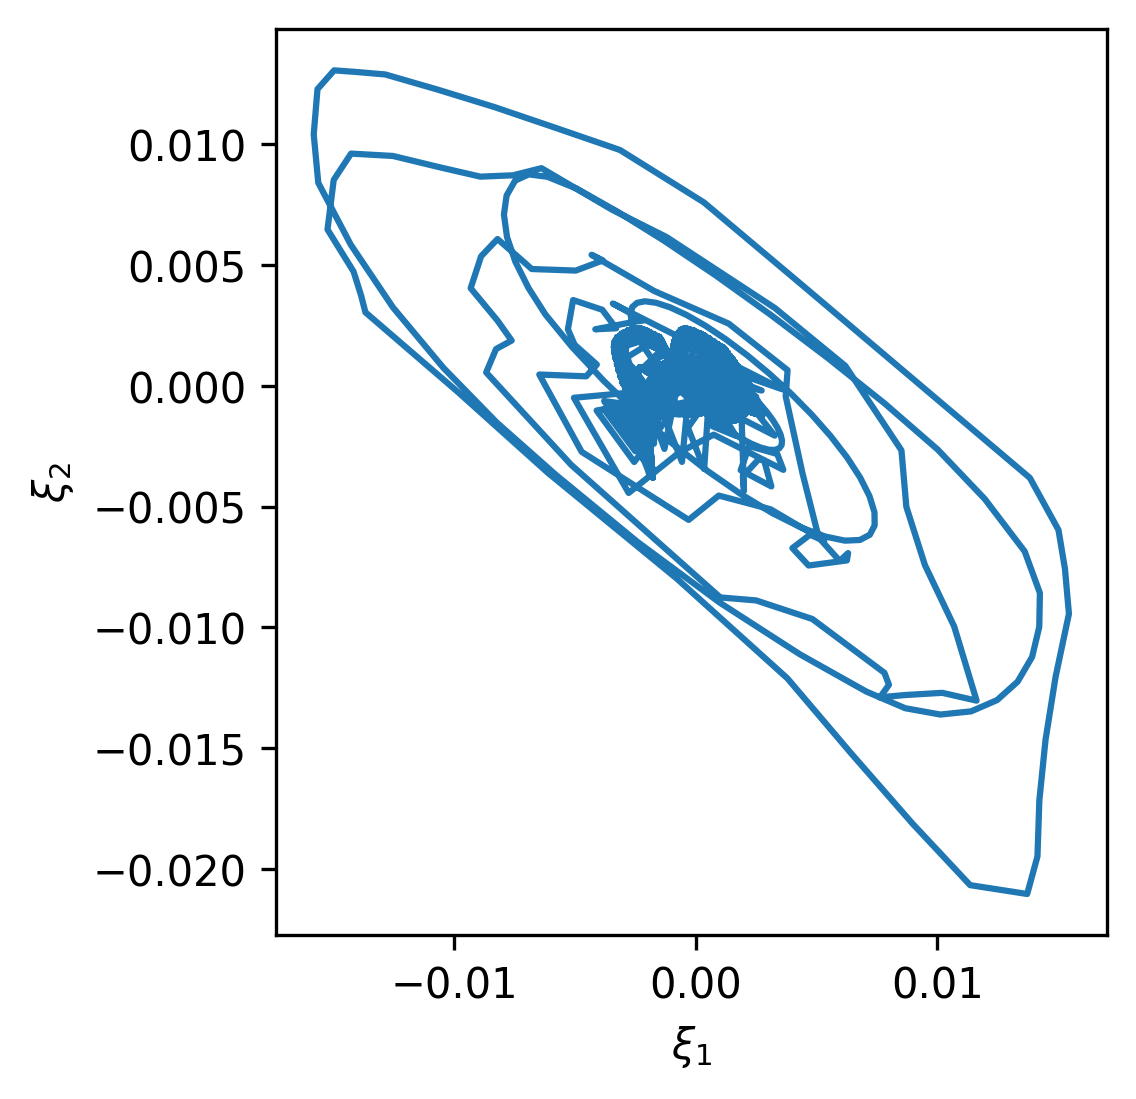

In [17]:
timesteps_latent = 2000
#plotting Memory evolution
plt.figure(dpi=300)
model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(np.arange(timesteps_latent)*0.2,xseq_ms_hat[model_num][0,:timesteps_latent,n].cpu().numpy(), label = r"$\xi$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\xi$")

plt.figure(dpi = 300)
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:timesteps_latent,0].cpu().numpy(), xseq_ms_hat[model_num][0,:timesteps_latent,1].cpu().numpy())
plt.xlabel(r"$\xi_{1}$")
plt.ylabel(r"$\xi_{2}$")


Dictionary has been saved to Plot_csv/norm_contribution.csv


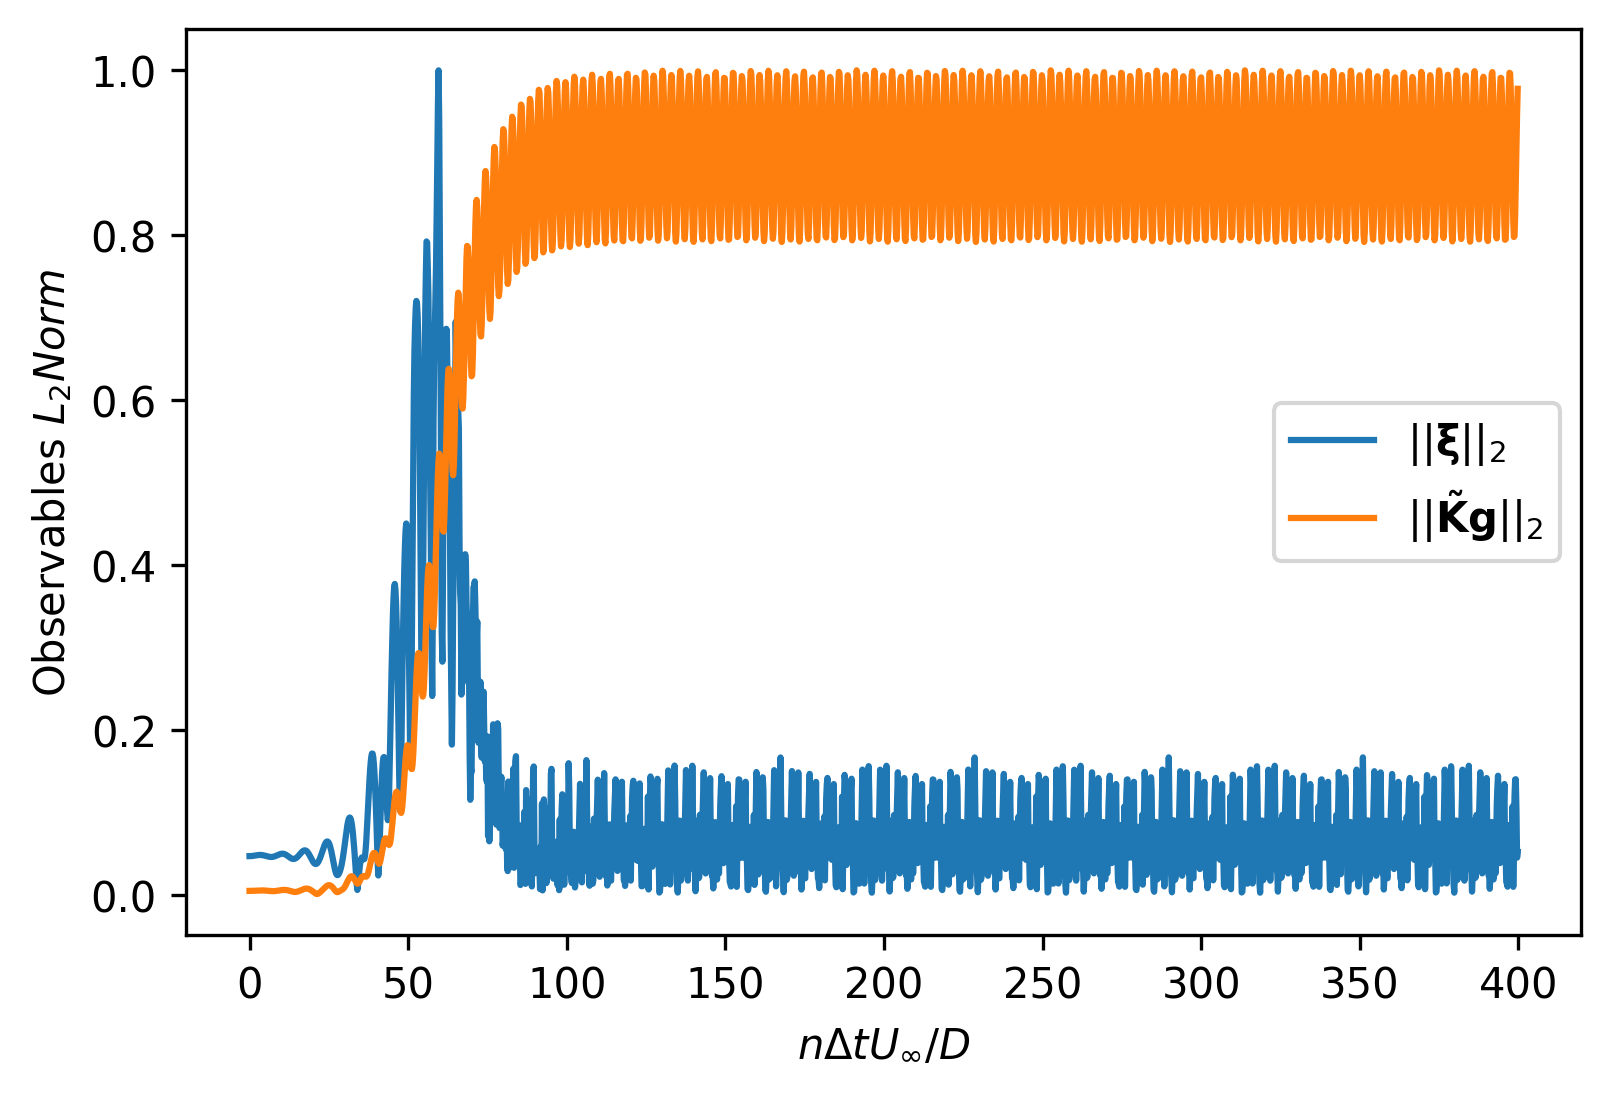

In [19]:
plt.figure(dpi = 300)
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)

plt.plot(np.arange(timesteps_latent)*0.2,(tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:timesteps_latent], label = r"$||\mathbf{\xi}||_{2}$")
plt.plot(np.arange(timesteps_latent)*0.2,(tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:timesteps_latent], label = r"$||\tilde{\mathbf{K}}\mathbf{g}||_{2}$")
plt.legend()
plt.xlabel(r"$n\Delta tU_{\infty}/D$")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

Mean Squared Error

torch.Size([1, 1421, 7938]) torch.Size([2, 1, 2001, 7938])


Text(0, 0.5, 'MSE')

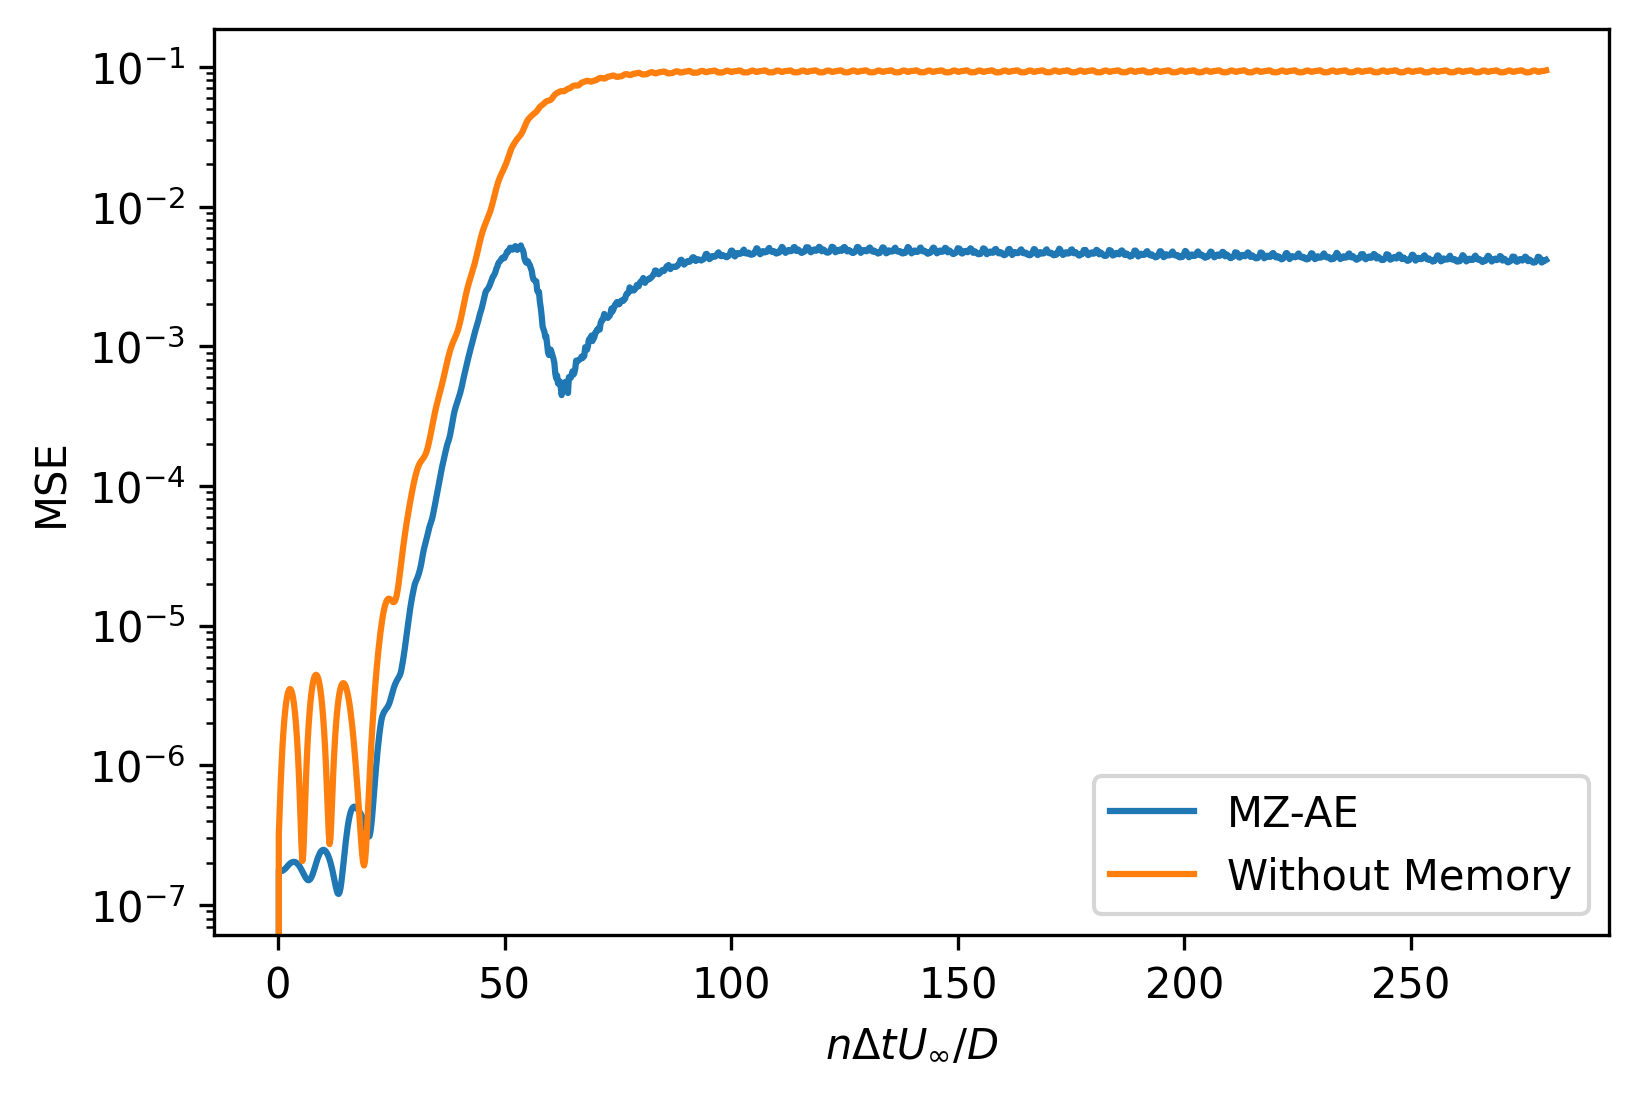

In [21]:
print(Phi_test.shape, Phi_ms_hat.shape)
timesteps_state_mse = 1400
State_MSE_multistep = torch.zeros((len(models),timesteps_state_mse))

plt.figure(dpi=300)
for i in [0,1]:
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_test[:,:timesteps_state_mse],Phi_ms_hat[i,:,:timesteps_state_mse]).detach().cpu()
    if i==0:
        plt.semilogy(np.arange(timesteps_state_mse)*0.2, State_MSE_multistep[i].numpy(), label = f"MZ-AE")
    else:
        plt.semilogy(np.arange(timesteps_state_mse)*0.2, State_MSE_multistep[i].numpy(), label = f"Without Memory")

plt.legend()
plt.xlabel(r"$n\Delta t U_{\infty}/D$")
plt.ylabel("MSE")

Koopman Spectrum

[0.00032532+0.17927666j 0.00032532-0.17927666j]
[0.00030537+0.1790844j 0.00030537-0.1790844j]


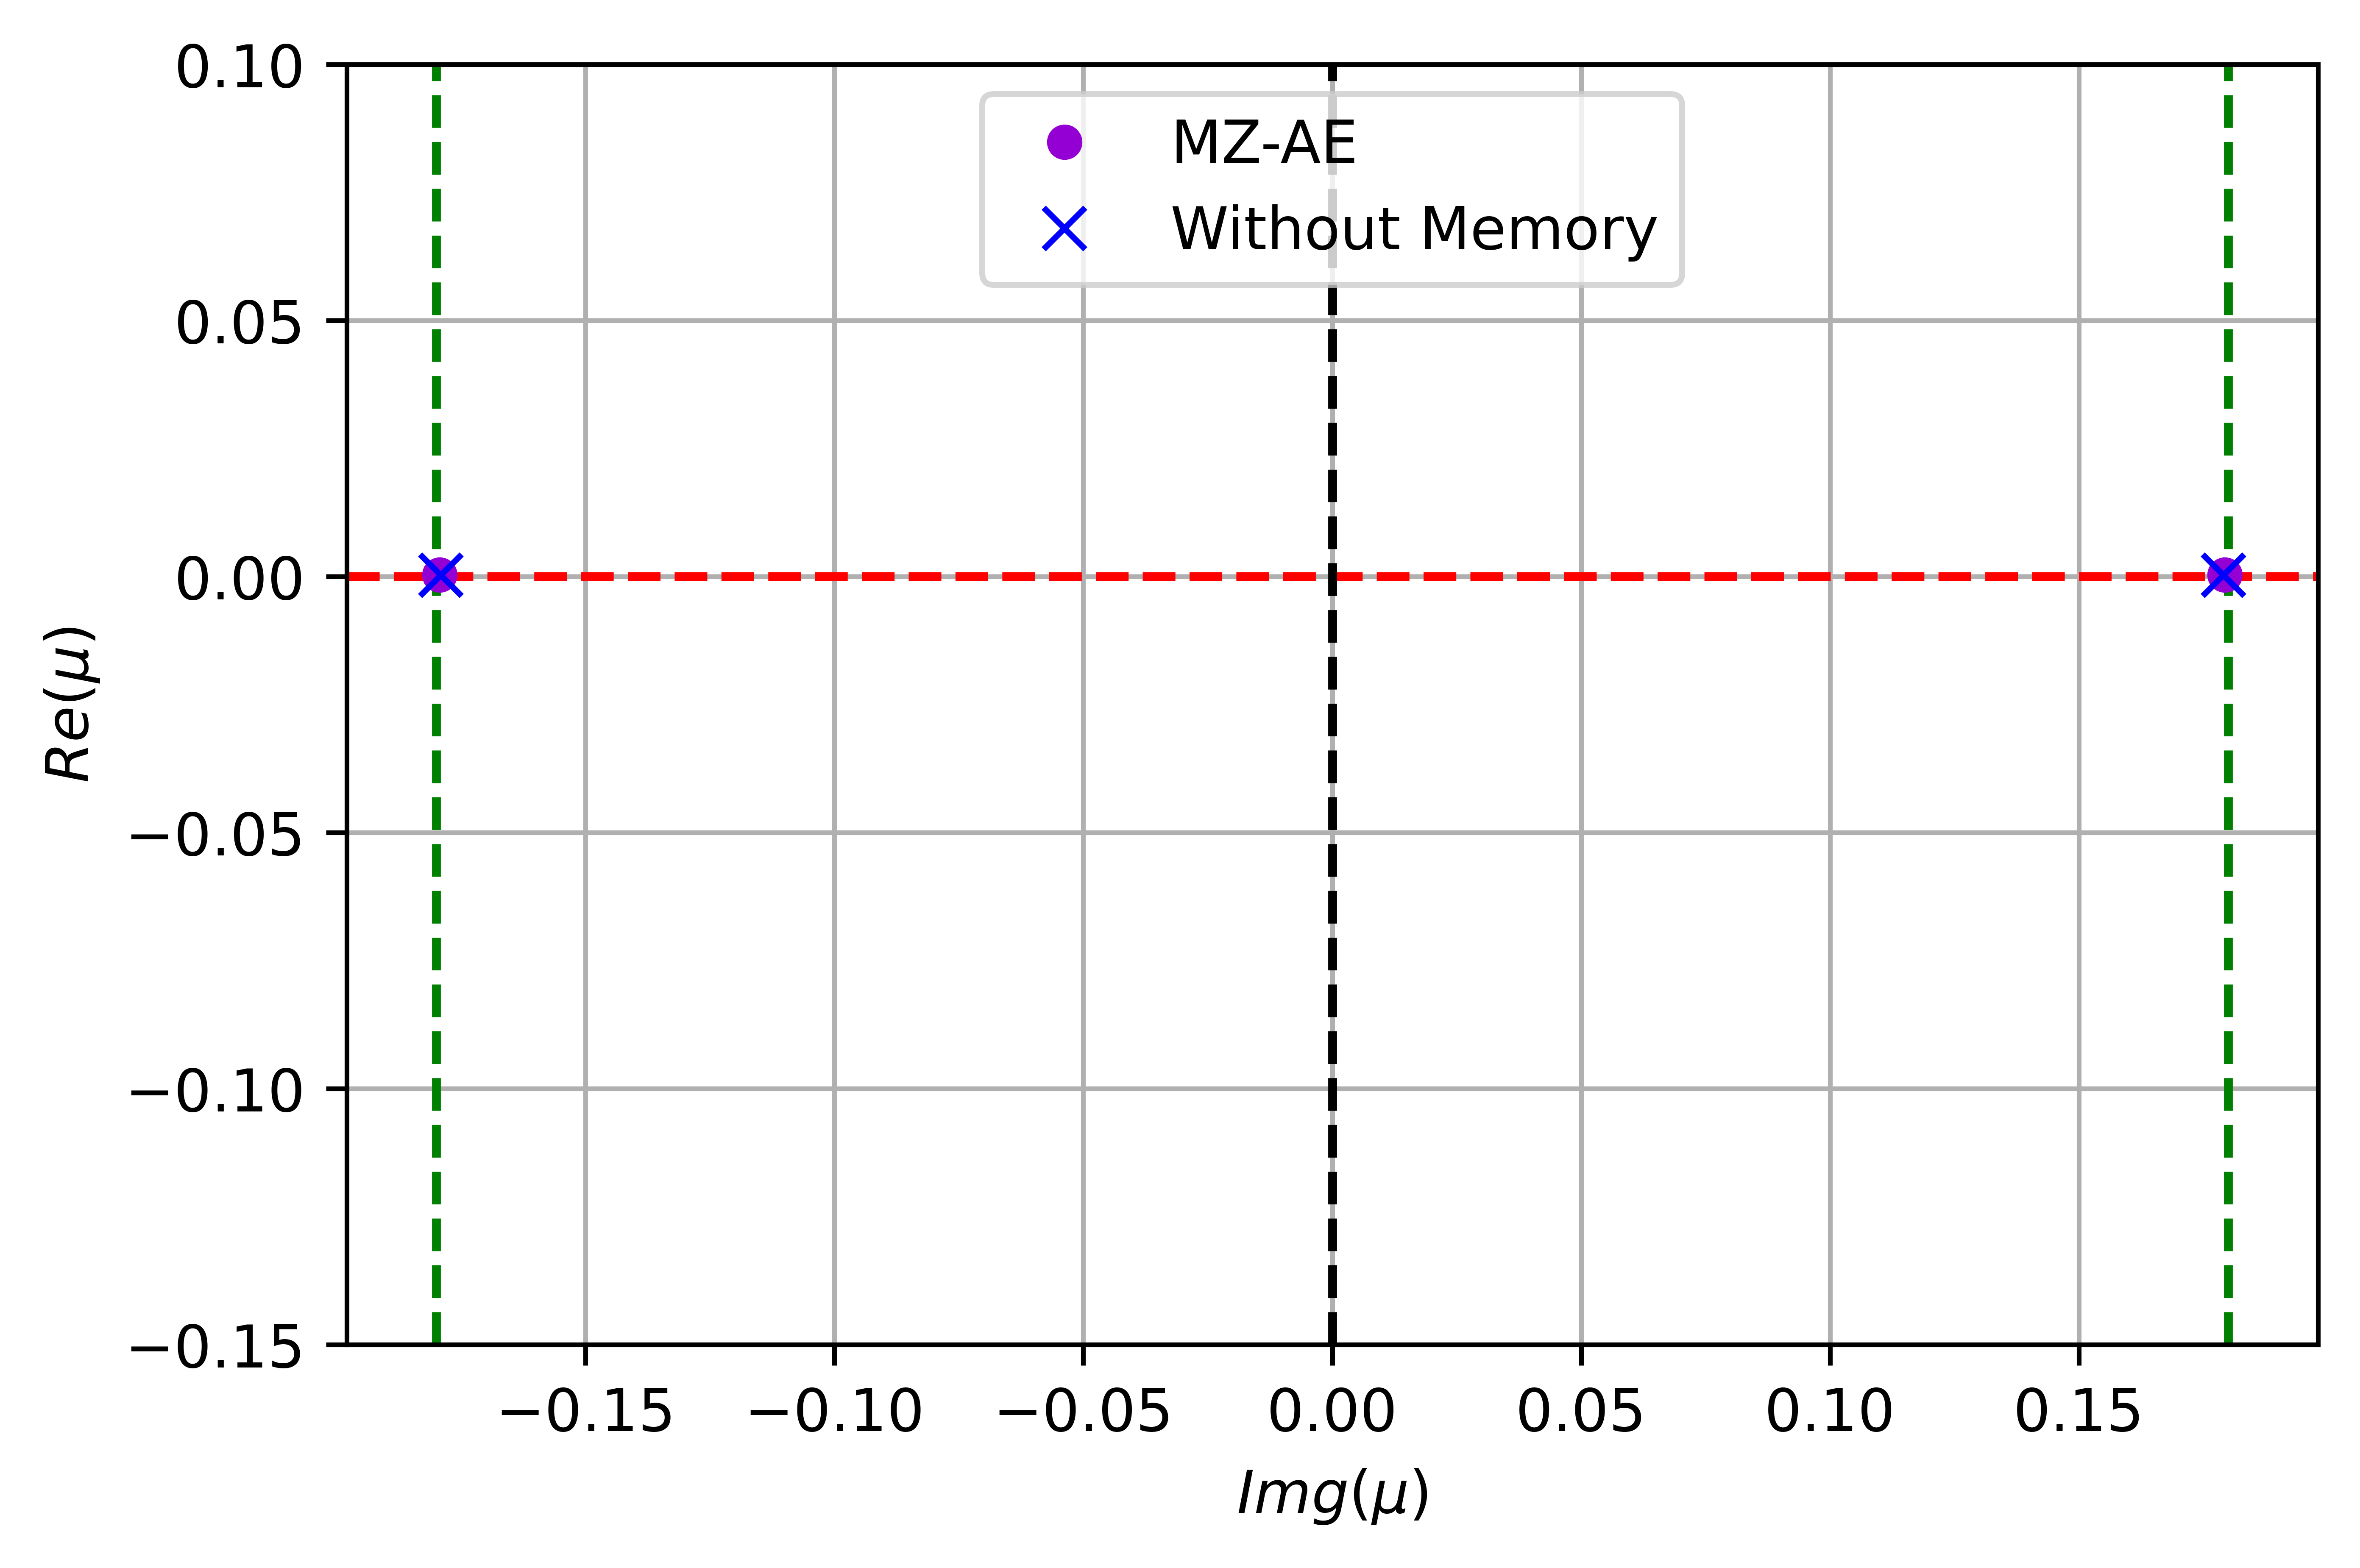

In [23]:
import copy
plt.figure(dpi = 1000)

plt.axhline(0, color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')
plt.axvline(0.18, color='green', linestyle='--')
plt.axvline(-0.18, color='green', linestyle='--')


for i in [0,1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.2)/(2*np.pi)
    print(lamb)

    if i == 0:
        plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", color = "darkviolet", markersize = 10, label = "MZ-AE")
        lamb_mzae = copy.deepcopy(lamb)
    else:
        plt.plot(np.imag(lamb[:]),np.real(lamb[:]),"x", color = "blue", markersize = 7, label = "Without Memory")
        lamb_wm = copy.deepcopy(lamb)
plt.ylabel(r"$Re(\mu)$")
plt.xlabel(r"$Img(\mu)$")
plt.grid("on")
plt.ylim(-0.15,0.1)
plt.legend(loc = "upper center")

